This is a fun project that I did to try out the pretrained models on datastream created from google images. It was a good practice in building data pipelines, creating image transforms, importing the pretrained models and optimizing the learning rate. 

I searched for images of some of the famous football players on google images and fed the first 200 images to this model to see how well the model is able to train on an uncurated noisy data.

Recognizing players can be an useful application in sport analytics. A lot of in-game metrics like xG and xA scores, heatmaps depend on some kind of deep learning algorithms running in the backend.

# **Setting up the libraries**


This step mounts the google drive in working enironment which would be used as a backend storage.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from fastai.vision import *

In [0]:
import warnings
warnings.filterwarnings("ignore")

# **Creating data pipeline**

In [4]:
ls

gdrive/  sample_data/


In [5]:
cd gdrive/My Drive/fastai_player_recog/

/content/gdrive/My Drive/fastai_player_recog


In [0]:
folder = 'cr'
file = 'cr.csv'

In [0]:
folder = 'messi'
file = 'messi.csv'

In [0]:
folder = 'suarez'
file = 'suarez.csv'

In [0]:
path = Path('data/players')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [10]:
path.ls

<bound method <lambda> of PosixPath('data/players')>

In [0]:
classes = ['cr','messi','suarez']

In [12]:
download_images(path/file, dest, max_pics=200)

In [13]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cr


messi


suarez


cannot identify image file <_io.BufferedReader name='data/players/suarez/00000070.jpg'>
cannot identify image file <_io.BufferedReader name='data/players/suarez/00000096.png'>


# **Modeling - Data Transformation**

**Transforms**

In [0]:
path = Path('data/players/')

In [15]:
path

PosixPath('data/players')

In [0]:
transforms = get_transforms()

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=transforms, size=224, bs=32).normalize(imagenet_stats)

In [18]:
data.classes

['cr', 'messi', 'suarez']

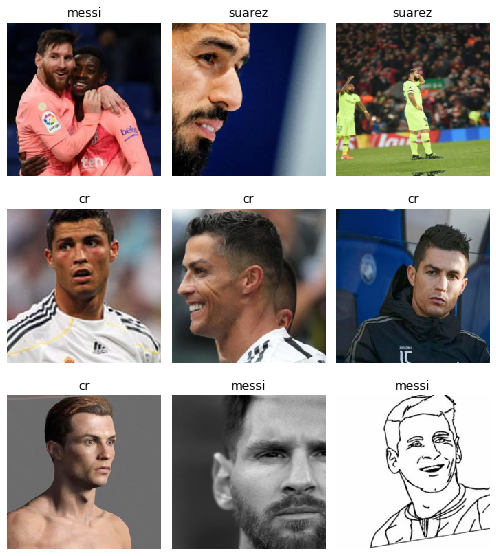

In [19]:
data.show_batch(rows=3, figsize=(7,8))

As you can see above, the dataset is uncurated with lot of noisy pictures. For example, the last picture is a sketch. There are several such images that are inaccurate/improper but we shall be using them to induce noise in our models.

In [20]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cr', 'messi', 'suarez'], 3, 383, 95)

# **Training**

As seen below, we are able to achieve around 87%-89% accuracy by optimizing the learning rate. If we now remove the noise from the data, we shall quite easily be able to achieve an even higher accuracy. It'd be interesting to see which images are misclassified the most.

In [0]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)

In [23]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,0.153895,0.486600,0.147368,00:08
1,0.176932,0.453679,0.147368,00:08
2,0.186371,0.438741,0.136842,00:08
3,0.176964,0.498095,0.126316,00:09
4,0.187868,0.495250,0.157895,00:08
5,0.173565,0.450809,0.147368,00:09
6,0.167043,0.444867,0.115789,00:09
7,0.161417,0.477105,0.178947,00:08
8,0.164916,0.773907,0.168421,00:08
9,0.157456,0.554971,0.189474,00:08


In [0]:
learn.save('stage-1')

In [0]:
learn.unfreeze()

In [37]:
learn.lr_find(stop_div=False, num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


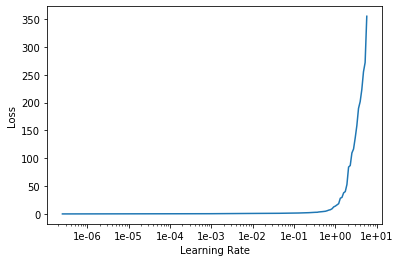

In [38]:
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(10, max_lr=slice(1e-03,1e-06))


epoch,train_loss,valid_loss,error_rate,time
0,0.067066,0.845543,0.178947,00:11
1,0.042421,1.085019,0.231579,00:11
2,0.106151,1.190116,0.284211,00:11
3,0.217121,5.310340,0.610526,00:11
4,0.304309,3.054987,0.578947,00:11
5,0.348517,1.629803,0.368421,00:11
6,0.353958,0.877336,0.200000,00:11
7,0.319123,0.604664,0.168421,00:11
8,0.277269,0.568268,0.136842,00:11
9,0.257772,0.594630,0.126316,00:11


In [0]:
learn.save('stage-2')

In [0]:
learn.freeze_to(100)

In [43]:
learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,error_rate,time
0,0.199813,0.610031,0.136842,00:08
1,0.169803,0.593857,0.136842,00:08
2,0.145744,0.590429,0.136842,00:08
3,0.139687,0.596360,0.147368,00:08
4,0.137717,0.611183,0.136842,00:08
5,0.122393,0.663416,0.136842,00:08
6,0.124853,0.701337,0.126316,00:08
7,0.136023,0.690178,0.136842,00:08
8,0.134810,0.711177,0.136842,00:08
9,0.133105,0.759611,0.136842,00:08


In [44]:
interp = ClassificationInterpretation.from_learner(learn)

Below shown are the images with highest losses. As you can see, most of it is noise. For example, the third image is an edited version, 6th and 9th images are graphic designs and not raw images.

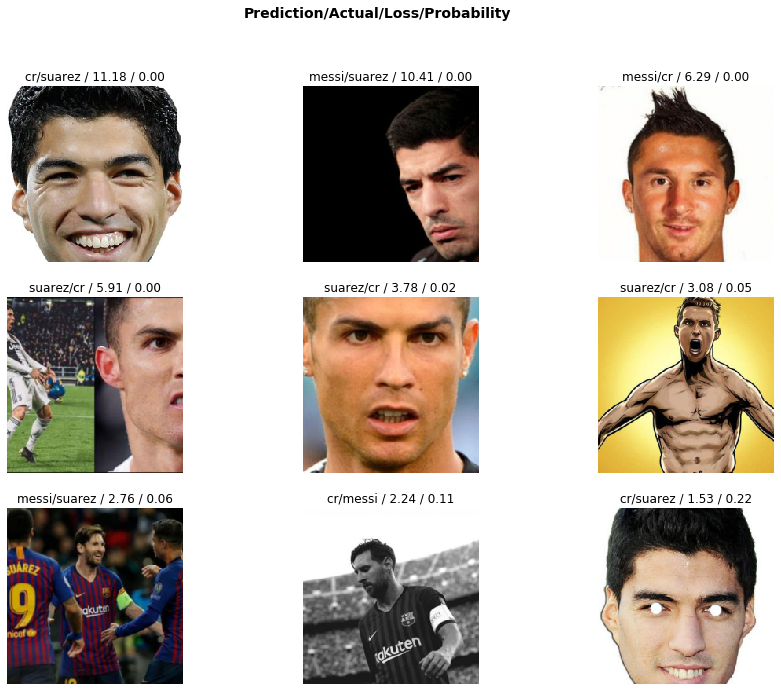

In [45]:
interp.plot_top_losses(9, figsize=(15,11))

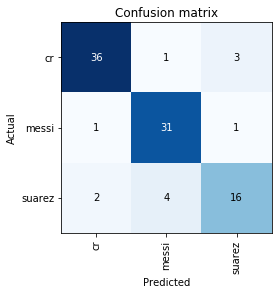

In [46]:
interp.plot_confusion_matrix()

The confusion matrix thus shows that the model is quite adept at classifying the images. It currently shows an accuracy of 87%-89%. The accuracy can further be improved by 
- increasing the data
- inceasing the computation effort
- removing the noise from data